# 第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [3]:
#colabを利用する上での前準備
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [5]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 70. 単語ベクトルの和による特徴量

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xi
の特徴ベクトルxi
を並べた行列X
と，正解ラベルを並べた行列（ベクトル）Y
を作成したい．

ここで，n
は学習データの事例数であり，xi∈ℝd
とyi∈ℕ
はそれぞれ，i∈{1,…,n}
番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．ℕ<4
で4
未満の自然数（0
を含む）を表すことにすれば，任意の事例の正解ラベルyi
はyi∈ℕ<4
で表現できる． 以降では，ラベルの種類数をL
で表す（今回の分類タスクではL=4
である）．

i
番目の事例の特徴ベクトルxi
は，次式で求める．

ここで，i
番目の事例はTi
個の（記事見出しの）単語列(wi,1,wi,2,…,wi,Ti)
から構成され，emb(w)∈ℝd
は単語w
に対応する単語ベクトル（次元数はd
）である．すなわち，i
番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものがxi
である．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300
次元の単語ベクトルを用いたので，d=300
である．

i
番目の事例のラベルyi
は，次のように定義する．

なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

学習データの特徴量行列: Xtrain∈ℝNt×d
学習データのラベルベクトル: Ytrain∈ℕNt
検証データの特徴量行列: Xvalid∈ℝNv×d
検証データのラベルベクトル: Yvalid∈ℕNv
評価データの特徴量行列: Xtest∈ℝNe×d
評価データのラベルベクトル: Ytest∈ℕNe
なお，Nt,Nv,Ne
はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．



In [6]:
#50と同様

import pandas as pd
from sklearn.model_selection import train_test_split

#データ読み込み #エラーが出るため、タブ区切り、ラベル名を指定する
df = pd.read_csv('./NewsAggregatorDataset/newsCorpora.csv', sep="\t", names=["id", "title", "url", "publisher", "category", "story", "hostname", "timestamp"])

#情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する
df = df[df['publisher'].isin(["Reuters", "Huffington Post", "Businessweek", "COntactmusic.com", "Daily Mail"])]

#抽出された事例をランダムに並び替える
df = df.sample(frac = 1, random_state = 42, ignore_index=True)

#抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する
train, test = train_test_split(df, test_size=0.2, random_state = 42)
test, valid = train_test_split(test, test_size=0.5, random_state = 42)

In [7]:
#60と同様

import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('./shogi/GoogleNews-vectors-negative300.bin.gz', binary= True)

In [8]:
import torch

train['title']

3790    So who was the Emmys' worst dressed? Lena Dunh...
4502    Japan's Controversial Whaling Program Suspende...
5940    Want Kate Middleton's iconic half updo? This s...
5858    Rare Diamond Shows Earth's Interior Is All Wet...
3334    Miley Cyrus escapes injury as her tour bus bur...
                              ...                        
5734    S&P 500, Dow Climb to Records on Tech Rally as...
5191    L'Wren Scott's Death Ruled A Suicide By NYC Of...
5390    Credit Suisse Said to Get New York Subpoena in...
860     US web companies press demands for net neutral...
7270    Hilary Duff Still Has 'A Lot Of Love' For Estr...
Name: title, Length: 8804, dtype: object

In [9]:
lis_train_vecs =[] #1文内の単語ベクトルのリスト
tensor_vecs = [] #平均単語ベクトルのリスト
for title in train['title']:
  lis_train_words = title.split()
  for word in lis_train_words:
    try:
      vec = model[word]
      lis_train_vecs.append(vec)

    except: #未知語の場合
      pass

  tensor_vec = torch.tensor(sum(lis_train_vecs) / len(lis_train_vecs))
  tensor_vecs.append(tensor_vec)
  lis_train_vecs =[]

X_train = torch.stack(tensor_vecs)

In [10]:
lis_train_vecs =[] #1文内の単語ベクトルのリスト
tensor_vecs = [] #平均単語ベクトルのリスト
for title in valid['title']:
  lis_train_words = title.split()
  for word in lis_train_words:
    try:
      vec = model[word]
      lis_train_vecs.append(vec)

    except: #未知語の場合
      pass

  tensor_vec = torch.tensor(sum(lis_train_vecs) / len(lis_train_vecs))
  tensor_vecs.append(tensor_vec)
  lis_train_vecs =[]

X_valid = torch.stack(tensor_vecs)

In [11]:
lis_train_vecs =[] #1文内の単語ベクトルのリスト
tensor_vecs = [] #平均単語ベクトルのリスト
for title in valid['title']:
  lis_train_words = title.split()
  for word in lis_train_words:
    try:
      vec = model[word]
      lis_train_vecs.append(vec)

    except: #未知語の場合
      pass

  tensor_vec = torch.tensor(sum(lis_train_vecs) / len(lis_train_vecs))
  tensor_vecs.append(tensor_vec)
  lis_train_vecs =[]

X_test = torch.stack(tensor_vecs)

In [12]:
# ターゲットのテンソル化
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['category'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['category'].map(category_dict).values)
Y_test = torch.from_numpy(test['category'].map(category_dict).values)
# 保存
torch.save(X_train, './NewsAggregatorDataset/X_train.pt')
torch.save(X_valid, './NewsAggregatorDataset/X_valid.pt')
torch.save(X_test, './NewsAggregatorDataset/X_test.pt')
torch.save(Y_train, './NewsAggregatorDataset/y_train.pt')
torch.save(Y_valid, './NewsAggregatorDataset/y_valid.pt')
torch.save(Y_test, './NewsAggregatorDataset/y_test.pt')

In [13]:
#確認
print(X_train)
print(Y_train)

tensor([[ 0.0704,  0.0600,  0.0520,  ...,  0.0093,  0.1410,  0.0667],
        [ 0.0536, -0.0164,  0.0868,  ..., -0.0089,  0.0265,  0.0666],
        [ 0.0374,  0.0011, -0.0588,  ..., -0.0348, -0.0233, -0.0400],
        ...,
        [-0.0046,  0.0939, -0.0272,  ..., -0.1045, -0.0858, -0.0159],
        [-0.0475,  0.0452, -0.0182,  ...,  0.1119, -0.0245, -0.0485],
        [ 0.0561, -0.0307, -0.1766,  ..., -0.0750,  0.0294, -0.0518]])
tensor([2, 1, 2,  ..., 0, 1, 2])


# 71. 単層ニューラルネットワークによる予測

問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

ただし，softmax
はソフトマックス関数，X[1:4]∈ℝ4×d
は特徴ベクトルx1,x2,x3,x4
を縦に並べた行列である．

行列W∈ℝd×L
は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，y1^∈ℝL
は未学習の行列W
で事例x1
を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，Ŷ ∈ℝn×L
は，学習データの事例x1,x2,x3,x4
について，各カテゴリに属する確率を行列として表現している．

In [14]:
from torch import nn

class SLPNet(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

In [15]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)

In [16]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)
print(Y_train[:4])

tensor([[0.1646, 0.4056, 0.1730, 0.2568],
        [0.0162, 0.2099, 0.0222, 0.7517],
        [0.2764, 0.2141, 0.0196, 0.4898],
        [0.0090, 0.6846, 0.0639, 0.2426]], grad_fn=<SoftmaxBackward0>)
tensor([2, 1, 2, 1])


# 72. 損失と勾配の計算

学習データの事例x1
と事例集合x1,x2,x3,x4
に対して，クロスエントロピー損失と，行列W
に対する勾配を計算せよ．なお，ある事例xi
に対して損失は次式で計算される．

li=−log[事例xiがyiに分類される確率]
ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [17]:
criterion = nn.CrossEntropyLoss()

l_1 = criterion(model(X_train[:1]), Y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.7542
勾配:
tensor([[ 0.0116,  0.0099,  0.0086,  ...,  0.0015,  0.0232,  0.0110],
        [ 0.0286,  0.0243,  0.0211,  ...,  0.0038,  0.0572,  0.0270],
        [-0.0583, -0.0496, -0.0430,  ..., -0.0077, -0.1166, -0.0551],
        [ 0.0181,  0.0154,  0.0134,  ...,  0.0024,  0.0362,  0.0171]])


In [18]:
l = criterion(model(X_train[:4]), Y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.9062
勾配:
tensor([[ 0.0056,  0.0024, -0.0016,  ..., -0.0022,  0.0045,  0.0002],
        [ 0.0030,  0.0115, -0.0134,  ...,  0.0076,  0.0016, -0.0078],
        [-0.0243, -0.0132,  0.0038,  ...,  0.0052, -0.0220, -0.0038],
        [ 0.0158, -0.0008,  0.0112,  ..., -0.0105,  0.0159,  0.0113]])


# 73. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [19]:
# データセットを作成する
import torch.utils.data as data

class NewsDataset(data.Dataset):
    """
    newsのDatasetクラス

    Attributes
    ----------------------------
    X : テンソル
        単語ベクトルの平均をまとめたテンソル
    y : テンソル
        カテゴリをラベル化したテンソル
    phase : 'train' or 'val'
        学習か訓練かを設定する
    """
    def __init__(self, X, y, phase='train'):
        self.X = X
        self.y = y
        self.phase = phase

    def __len__(self):
        """全データサイズを返す"""
        return len(self.y)

    def __getitem__(self, idx):
        """idxに対応するテンソル形式のデータとラベルを取得"""
        return self.X[idx], self.y[idx]

train_dataset = NewsDataset(X_train, Y_train, phase='train')
valid_dataset = NewsDataset(X_valid, Y_valid, phase='val')
test_dataset = NewsDataset(X_test, Y_test, phase='val')

# 動作確認
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])
print(valid_dataset.__getitem__(idx)[0].size())
print(valid_dataset.__getitem__(idx)[1])
print(test_dataset.__getitem__(idx)[0].size())
print(test_dataset.__getitem__(idx)[1])

torch.Size([300])
tensor(2)
torch.Size([300])
tensor(0)
torch.Size([300])
tensor(0)


In [20]:
# DataLoaderを作成
batch_size = 1

train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=len(test_dataset), shuffle=False)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)
print(inputs.size())
print(labels)

torch.Size([1, 300])
tensor([0])


In [21]:
from tqdm import tqdm
# 学習

# モデルの定義
net = SLPNet(300, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

# 学習を実行する
num_epochs = 10
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 2133.54it/s]


train Loss: 0.5779, Acc: 0.7923


100%|██████████| 1/1 [00:00<00:00, 76.65it/s]


val Loss: 0.4942, Acc: 0.8229
Epoch 2 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 2032.17it/s]


train Loss: 0.4054, Acc: 0.8582


100%|██████████| 1/1 [00:00<00:00, 65.67it/s]


val Loss: 0.4358, Acc: 0.8538
Epoch 3 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1833.61it/s]


train Loss: 0.3691, Acc: 0.8720


100%|██████████| 1/1 [00:00<00:00, 115.94it/s]


val Loss: 0.3989, Acc: 0.8610
Epoch 4 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 2058.57it/s]


train Loss: 0.3497, Acc: 0.8778


100%|██████████| 1/1 [00:00<00:00, 30.69it/s]


val Loss: 0.4054, Acc: 0.8556
Epoch 5 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1957.33it/s]


train Loss: 0.3389, Acc: 0.8823


100%|██████████| 1/1 [00:00<00:00, 88.42it/s]


val Loss: 0.3918, Acc: 0.8592
Epoch 6 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1881.04it/s]


train Loss: 0.3292, Acc: 0.8849


100%|██████████| 1/1 [00:00<00:00, 107.39it/s]


val Loss: 0.3883, Acc: 0.8610
Epoch 7 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 2170.98it/s]


train Loss: 0.3224, Acc: 0.8882


100%|██████████| 1/1 [00:00<00:00, 117.14it/s]


val Loss: 0.4010, Acc: 0.8601
Epoch 8 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 2165.23it/s]


train Loss: 0.3186, Acc: 0.8900


100%|██████████| 1/1 [00:00<00:00, 84.62it/s]


val Loss: 0.3813, Acc: 0.8592
Epoch 9 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1654.88it/s]


train Loss: 0.3145, Acc: 0.8923


100%|██████████| 1/1 [00:00<00:00, 76.42it/s]


val Loss: 0.3797, Acc: 0.8710
Epoch 10 / 10
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 2176.82it/s]


train Loss: 0.3112, Acc: 0.8939


100%|██████████| 1/1 [00:00<00:00, 109.61it/s]

val Loss: 0.3657, Acc: 0.8765


# 74. 正解率の計測

問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [20]:
def calc_acc(net, dataloader):
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data)
    return corrects / len(dataloader.dataset)

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

学習データの正解率: 0.8970
検証データの正解率: 0.8692
テストデータの正解率: 0.3760


# 75. 損失と正解率のプロット

問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [21]:
# 学習

#epochごとのlossと正解率をappendするリストを用意
epoch_loss_train_lis = []
epoch_acc_train_lis = []
epoch_loss_val_lis = []
epoch_acc_val_lis = []

#以下は問題73と同様

# モデルの定義
net = SLPNet(300, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # epochごとlossと正解率の表示をlistにappendする #問題75挿入箇所
            if phase == 'train':                      #SLPNet.train():訓練モードの場合、訓練データのlossとaccuracyを求める
              epoch_loss_train_lis.append(epoch_loss) #epoch_lossは各エポックにおけるloss
              epoch_acc_train_lis.append(epoch_acc)   #epoch_accは各エポックにおけるaccuracy

            else:  # phase == 'val'の場合              #SLPNet.eval():検証モードの場合、検証データのlossとaccuracyを求める
              epoch_loss_val_lis.append(epoch_loss)
              epoch_acc_val_lis.append(epoch_acc)


# 学習を実行する
num_epochs = 30 #エポック数は30とする
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1901.02it/s]


train Loss: 0.5952, Acc: 0.7875


100%|██████████| 1/1 [00:00<00:00, 74.57it/s]


val Loss: 0.4704, Acc: 0.8338
Epoch 2 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1548.54it/s]


train Loss: 0.4034, Acc: 0.8602


100%|██████████| 1/1 [00:00<00:00, 98.74it/s]


val Loss: 0.4292, Acc: 0.8456
Epoch 3 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1907.15it/s]


train Loss: 0.3665, Acc: 0.8710


100%|██████████| 1/1 [00:00<00:00, 109.14it/s]


val Loss: 0.4024, Acc: 0.8556
Epoch 4 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1905.86it/s]


train Loss: 0.3485, Acc: 0.8778


100%|██████████| 1/1 [00:00<00:00, 48.27it/s]


val Loss: 0.3846, Acc: 0.8619
Epoch 5 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1557.38it/s]


train Loss: 0.3361, Acc: 0.8838


100%|██████████| 1/1 [00:00<00:00, 83.62it/s]


val Loss: 0.3743, Acc: 0.8674
Epoch 6 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1944.43it/s]


train Loss: 0.3280, Acc: 0.8876


100%|██████████| 1/1 [00:00<00:00, 80.16it/s]


val Loss: 0.3705, Acc: 0.8683
Epoch 7 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1821.80it/s]


train Loss: 0.3211, Acc: 0.8882


100%|██████████| 1/1 [00:00<00:00, 58.19it/s]


val Loss: 0.3749, Acc: 0.8674
Epoch 8 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1628.43it/s]


train Loss: 0.3177, Acc: 0.8890


100%|██████████| 1/1 [00:00<00:00, 113.32it/s]


val Loss: 0.3612, Acc: 0.8701
Epoch 9 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1928.96it/s]


train Loss: 0.3135, Acc: 0.8927


100%|██████████| 1/1 [00:00<00:00, 71.48it/s]


val Loss: 0.3742, Acc: 0.8656
Epoch 10 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1765.01it/s]


train Loss: 0.3097, Acc: 0.8918


100%|██████████| 1/1 [00:00<00:00, 50.82it/s]


val Loss: 0.3658, Acc: 0.8710
Epoch 11 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1660.43it/s]


train Loss: 0.3078, Acc: 0.8933


100%|██████████| 1/1 [00:00<00:00, 109.36it/s]


val Loss: 0.3640, Acc: 0.8656
Epoch 12 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1922.17it/s]


train Loss: 0.3061, Acc: 0.8948


100%|██████████| 1/1 [00:00<00:00, 95.15it/s]


val Loss: 0.3644, Acc: 0.8710
Epoch 13 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1678.89it/s]


train Loss: 0.3037, Acc: 0.8935


100%|██████████| 1/1 [00:00<00:00, 72.98it/s]


val Loss: 0.3706, Acc: 0.8710
Epoch 14 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1741.44it/s]


train Loss: 0.3016, Acc: 0.8972


100%|██████████| 1/1 [00:00<00:00, 80.62it/s]


val Loss: 0.3753, Acc: 0.8656
Epoch 15 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1920.56it/s]


train Loss: 0.3014, Acc: 0.8930


100%|██████████| 1/1 [00:00<00:00, 114.46it/s]


val Loss: 0.3845, Acc: 0.8647
Epoch 16 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1643.29it/s]


train Loss: 0.2992, Acc: 0.8964


100%|██████████| 1/1 [00:00<00:00, 51.08it/s]


val Loss: 0.3564, Acc: 0.8747
Epoch 17 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1799.66it/s]


train Loss: 0.2995, Acc: 0.8946


100%|██████████| 1/1 [00:00<00:00, 73.55it/s]


val Loss: 0.3692, Acc: 0.8765
Epoch 18 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1915.35it/s]


train Loss: 0.2970, Acc: 0.8958


100%|██████████| 1/1 [00:00<00:00, 95.14it/s]


val Loss: 0.3653, Acc: 0.8774
Epoch 19 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1558.08it/s]


train Loss: 0.2974, Acc: 0.8973


100%|██████████| 1/1 [00:00<00:00, 64.18it/s]


val Loss: 0.3672, Acc: 0.8728
Epoch 20 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1877.30it/s]


train Loss: 0.2963, Acc: 0.8979


100%|██████████| 1/1 [00:00<00:00, 79.50it/s]


val Loss: 0.3884, Acc: 0.8692
Epoch 21 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1922.62it/s]


train Loss: 0.2953, Acc: 0.8994


100%|██████████| 1/1 [00:00<00:00, 111.87it/s]


val Loss: 0.3822, Acc: 0.8674
Epoch 22 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1527.35it/s]


train Loss: 0.2952, Acc: 0.8973


100%|██████████| 1/1 [00:00<00:00, 107.85it/s]


val Loss: 0.3716, Acc: 0.8692
Epoch 23 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1925.51it/s]


train Loss: 0.2941, Acc: 0.8953


100%|██████████| 1/1 [00:00<00:00, 111.61it/s]


val Loss: 0.3828, Acc: 0.8665
Epoch 24 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1932.38it/s]


train Loss: 0.2932, Acc: 0.8988


100%|██████████| 1/1 [00:00<00:00, 76.62it/s]


val Loss: 0.3665, Acc: 0.8747
Epoch 25 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1544.64it/s]


train Loss: 0.2926, Acc: 0.8985


100%|██████████| 1/1 [00:00<00:00, 101.55it/s]


val Loss: 0.3602, Acc: 0.8710
Epoch 26 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1970.46it/s]


train Loss: 0.2931, Acc: 0.8986


100%|██████████| 1/1 [00:00<00:00, 112.38it/s]


val Loss: 0.3630, Acc: 0.8719
Epoch 27 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1944.72it/s]


train Loss: 0.2922, Acc: 0.8989


100%|██████████| 1/1 [00:00<00:00, 83.41it/s]


val Loss: 0.3704, Acc: 0.8765
Epoch 28 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:05<00:00, 1551.37it/s]


train Loss: 0.2910, Acc: 0.8993


100%|██████████| 1/1 [00:00<00:00, 107.10it/s]


val Loss: 0.3718, Acc: 0.8701
Epoch 29 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1939.93it/s]


train Loss: 0.2912, Acc: 0.8994


100%|██████████| 1/1 [00:00<00:00, 78.98it/s]


val Loss: 0.3650, Acc: 0.8719
Epoch 30 / 30
--------------------------------------------


100%|██████████| 8804/8804 [00:04<00:00, 1873.04it/s]


train Loss: 0.2911, Acc: 0.9002


100%|██████████| 1/1 [00:00<00:00, 65.71it/s]

val Loss: 0.3690, Acc: 0.8728


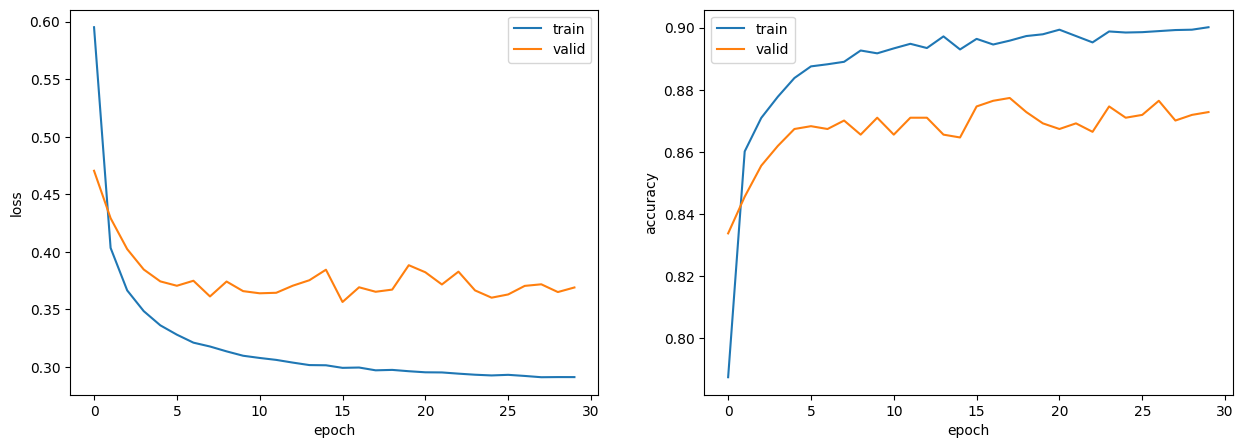

In [22]:
from matplotlib import pyplot as plt
import numpy as np

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(epoch_loss_train_lis, label='train')
ax[0].plot(epoch_loss_val_lis, label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(epoch_acc_train_lis, label='train')
ax[1].plot(epoch_acc_val_lis, label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

# 76. チェックポイント

問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [23]:
#学習途中のパラメータはnet.state_dict()、最適化アルゴリズムのバイブ状態はoptimizer.state_dict()でアクセス可能。

# モデルの定義
net = SLPNet(300, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch + 1, num_epochs))
        print('--------------------------------------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

                    # チェックポイントの保存
                    torch.save({'epoch': epoch, 'model_state_dict': net.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

# 学習を実行する
num_epochs = 10 #エポック数は10とする
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


Epoch 2 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 39.40it/s]


Epoch 3 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 62.25it/s]


Epoch 4 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 63.54it/s]


Epoch 5 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 27.53it/s]


Epoch 6 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 72.18it/s]


Epoch 7 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


Epoch 8 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 56.58it/s]


Epoch 9 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 79.14it/s]


Epoch 10 / 10
--------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 62.14it/s]


# 77. ミニバッチ化

問題76のコードを改変し，B
事例ごとに損失・勾配を計算し，行列W
の値を更新せよ（ミニバッチ化）．B
の値を1,2,4,8,…
と変化させながら，1エポックの学習に要する時間を比較せよ．

In [34]:
import time

#epochごとのlossと正解率をappendするリストを用意
epoch_loss_train_lis = []
epoch_acc_train_lis = []
epoch_loss_val_lis = []
epoch_acc_val_lis = []

def model(train_dataset, valid_dataset, batch_size, net, criterion, optimizer, num_epochs):

  # DataLoaderを作成
  train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
  valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=len(valid_dataset), shuffle=False)

  # 学習
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time =time.time()


    # epochごとの学習と検証のループ
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train() # 訓練モード
        else:
            net.eval() # 検証モード

        epoch_loss = 0.0 # epochの損失和
        epoch_corrects = 0 # epochの正解数

        # データローダーからミニバッチを取り出すループ
        for inputs, labels in tqdm(dataloaders_dict[phase]):
            optimizer.zero_grad() # optimizerを初期化

            # 順伝播計算(forward)
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                loss = criterion(outputs, labels) # 損失を計算
                _, preds = torch.max(outputs, 1) # ラベルを予想

                # 訓練時は逆伝播
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # イテレーション結果の計算
                # lossの合計を更新
                epoch_loss += loss.item() * inputs.size(0)
                # 正解数の合計を更新
                epoch_corrects += torch.sum(preds == labels.data)

                # チェックポイントの保存
                torch.save({'epoch': epoch, 'model_state_dict': net.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # epochごとのlossと正解率の表示
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        # epochごとlossと正解率の表示をlistにappendする #問題75挿入箇所
        if phase == 'train':
          epoch_loss_train_lis.append(epoch_loss)
          epoch_acc_train_lis.append(epoch_acc)

        else:  # phase == 'test'の場合
          epoch_loss_val_lis.append(epoch_loss)
          epoch_acc_val_lis.append(epoch_acc)

        print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # 終了時刻の記録
        e_time = time.time()
        calc_time = e_time - s_time
        print('batch_size {} calc_time: {:.4f} sec'.format(batch_size, calc_time))

  return epoch_loss_train_lis, epoch_acc_train_lis, epoch_loss_val_lis, epoch_acc_val_lis, calc_time

# データセットの作成
train_dataset = NewsDataset(X_train, Y_train, phase='train')
valid_dataset = NewsDataset(X_valid, Y_valid, phase='val')
test_dataset = NewsDataset(X_test, Y_test, phase='val')

# モデルの定義
net = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = model(train_dataset, valid_dataset, batch_size, net, criterion, optimizer, 1)


バッチサイズ: 1


100%|██████████| 8804/8804 [00:56<00:00, 154.52it/s]


train Loss: 0.5658, Acc: 0.7940
batch_size 1 calc_time: 56.9914 sec


100%|██████████| 1/1 [00:00<00:00, 43.06it/s]


val Loss: 0.4460, Acc: 0.8429
batch_size 1 calc_time: 57.0257 sec
バッチサイズ: 2


100%|██████████| 8804/8804 [00:55<00:00, 157.69it/s]


train Loss: 0.3967, Acc: 0.8610
batch_size 2 calc_time: 55.8417 sec


100%|██████████| 1/1 [00:00<00:00, 55.62it/s]


val Loss: 0.4013, Acc: 0.8610
batch_size 2 calc_time: 55.8688 sec
バッチサイズ: 4


100%|██████████| 8804/8804 [01:00<00:00, 144.70it/s]


train Loss: 0.3637, Acc: 0.8745
batch_size 4 calc_time: 60.8520 sec


100%|██████████| 1/1 [00:00<00:00, 31.90it/s]


val Loss: 0.3869, Acc: 0.8638
batch_size 4 calc_time: 60.8955 sec
バッチサイズ: 8


100%|██████████| 8804/8804 [00:57<00:00, 153.75it/s]


train Loss: 0.3469, Acc: 0.8808
batch_size 8 calc_time: 57.2715 sec


100%|██████████| 1/1 [00:00<00:00, 63.82it/s]


val Loss: 0.3794, Acc: 0.8592
batch_size 8 calc_time: 57.2970 sec
バッチサイズ: 16


100%|██████████| 8804/8804 [00:58<00:00, 151.01it/s]


train Loss: 0.3352, Acc: 0.8838
batch_size 16 calc_time: 58.3117 sec


100%|██████████| 1/1 [00:00<00:00, 67.02it/s]


val Loss: 0.3707, Acc: 0.8719
batch_size 16 calc_time: 58.3366 sec
バッチサイズ: 32


100%|██████████| 8804/8804 [00:55<00:00, 157.39it/s]


train Loss: 0.3274, Acc: 0.8872
batch_size 32 calc_time: 55.9454 sec


100%|██████████| 1/1 [00:00<00:00, 62.21it/s]


val Loss: 0.3607, Acc: 0.8728
batch_size 32 calc_time: 55.9723 sec
バッチサイズ: 64


100%|██████████| 8804/8804 [00:55<00:00, 159.48it/s]


train Loss: 0.3226, Acc: 0.8876
batch_size 64 calc_time: 55.2223 sec


100%|██████████| 1/1 [00:00<00:00, 36.87it/s]


val Loss: 0.3633, Acc: 0.8665
batch_size 64 calc_time: 55.2575 sec
バッチサイズ: 128


100%|██████████| 8804/8804 [00:55<00:00, 159.62it/s]


train Loss: 0.3171, Acc: 0.8894
batch_size 128 calc_time: 55.1654 sec


100%|██████████| 1/1 [00:00<00:00, 29.81it/s]


val Loss: 0.3678, Acc: 0.8710
batch_size 128 calc_time: 55.2127 sec
バッチサイズ: 256


100%|██████████| 8804/8804 [00:55<00:00, 157.68it/s]


train Loss: 0.3127, Acc: 0.8920
batch_size 256 calc_time: 55.8445 sec


100%|██████████| 1/1 [00:00<00:00, 52.17it/s]


val Loss: 0.3587, Acc: 0.8701
batch_size 256 calc_time: 55.8741 sec
バッチサイズ: 512


100%|██████████| 8804/8804 [00:54<00:00, 161.52it/s]


train Loss: 0.3103, Acc: 0.8939
batch_size 512 calc_time: 54.5177 sec


100%|██████████| 1/1 [00:00<00:00, 82.57it/s]


val Loss: 0.3613, Acc: 0.8701
batch_size 512 calc_time: 54.5410 sec
バッチサイズ: 1024


100%|██████████| 8804/8804 [00:55<00:00, 159.49it/s]


train Loss: 0.3060, Acc: 0.8936
batch_size 1024 calc_time: 55.2143 sec


100%|██████████| 1/1 [00:00<00:00, 75.03it/s]

val Loss: 0.3752, Acc: 0.8719
batch_size 1024 calc_time: 55.2361 sec


# 78. GPU上での学習

問題77のコードを改変し，GPU上で学習を実行せよ．

In [24]:
import time

#epochごとのlossと正解率をappendするリストを用意
epoch_loss_train_lis = []
epoch_acc_train_lis = []
epoch_loss_val_lis = []
epoch_acc_val_lis = []

def model(train_dataset, valid_dataset, batch_size, net, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  net.to(device) #追加

  # DataLoaderを作成
  train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
  valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=len(valid_dataset), shuffle=False)

  # 学習
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time =time.time()


    # epochごとの学習と検証のループ
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train() # 訓練モード
        else:
            net.eval() # 検証モード

        epoch_loss = 0.0 # epochの損失和
        epoch_corrects = 0 # epochの正解数

        # データローダーからミニバッチを取り出すループ
        for inputs, labels in tqdm(dataloaders_dict[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # optimizerを初期化

            # 順伝播計算(forward)
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                loss = criterion(outputs, labels) # 損失を計算
                _, preds = torch.max(outputs, 1) # ラベルを予想

                # 訓練時は逆伝播
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # イテレーション結果の計算
                # lossの合計を更新
                epoch_loss += loss.item() * inputs.size(0)
                # 正解数の合計を更新
                epoch_corrects += torch.sum(preds == labels.data)

                # チェックポイントの保存
                torch.save({'epoch': epoch, 'model_state_dict': net.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # epochごとのlossと正解率の表示
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        # epochごとlossと正解率の表示をlistにappendする #問題75挿入箇所
        if phase == 'train':
          epoch_loss_train_lis.append(epoch_loss)
          epoch_acc_train_lis.append(epoch_acc)

        else:  # phase == 'test'の場合
          epoch_loss_val_lis.append(epoch_loss)
          epoch_acc_val_lis.append(epoch_acc)

        print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # 終了時刻の記録
        e_time = time.time()
        calc_time = e_time - s_time
        print('batch_size {} calc_time: {:.4f} sec'.format(batch_size, calc_time))

  return epoch_loss_train_lis, epoch_acc_train_lis, epoch_loss_val_lis, epoch_acc_val_lis, calc_time

# データセットの作成
train_dataset = NewsDataset(X_train, Y_train, phase='train')
valid_dataset = NewsDataset(X_valid, Y_valid, phase='val')
test_dataset = NewsDataset(X_test, Y_test, phase='val')

# モデルの定義
net = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = model(train_dataset, valid_dataset, batch_size, net, criterion, optimizer, 1, device=device)

バッチサイズ: 1


100%|██████████| 8804/8804 [00:53<00:00, 164.69it/s]


train Loss: 0.5763, Acc: 0.7950
batch_size 1 calc_time: 53.4732 sec


100%|██████████| 1/1 [00:00<00:00, 70.84it/s]


val Loss: 0.4470, Acc: 0.8429
batch_size 1 calc_time: 53.4941 sec
バッチサイズ: 2


100%|██████████| 8804/8804 [00:50<00:00, 173.90it/s]


train Loss: 0.4021, Acc: 0.8570
batch_size 2 calc_time: 50.6350 sec


100%|██████████| 1/1 [00:00<00:00, 78.21it/s]


val Loss: 0.4026, Acc: 0.8538
batch_size 2 calc_time: 50.6573 sec
バッチサイズ: 4


100%|██████████| 8804/8804 [00:48<00:00, 180.14it/s]


train Loss: 0.3666, Acc: 0.8713
batch_size 4 calc_time: 48.8770 sec


100%|██████████| 1/1 [00:00<00:00, 72.28it/s]


val Loss: 0.3989, Acc: 0.8529
batch_size 4 calc_time: 48.8989 sec
バッチサイズ: 8


100%|██████████| 8804/8804 [00:49<00:00, 179.26it/s]


train Loss: 0.3480, Acc: 0.8790
batch_size 8 calc_time: 49.1196 sec


100%|██████████| 1/1 [00:00<00:00, 81.18it/s]


val Loss: 0.3755, Acc: 0.8647
batch_size 8 calc_time: 49.1401 sec
バッチサイズ: 16


100%|██████████| 8804/8804 [00:48<00:00, 180.20it/s]


train Loss: 0.3379, Acc: 0.8841
batch_size 16 calc_time: 48.8703 sec


100%|██████████| 1/1 [00:00<00:00, 52.10it/s]


val Loss: 0.3769, Acc: 0.8638
batch_size 16 calc_time: 48.8980 sec
バッチサイズ: 32


100%|██████████| 8804/8804 [00:48<00:00, 180.66it/s]


train Loss: 0.3296, Acc: 0.8845
batch_size 32 calc_time: 48.7468 sec


100%|██████████| 1/1 [00:00<00:00, 84.35it/s]


val Loss: 0.3656, Acc: 0.8728
batch_size 32 calc_time: 48.7691 sec
バッチサイズ: 64


100%|██████████| 8804/8804 [00:49<00:00, 179.26it/s]


train Loss: 0.3233, Acc: 0.8863
batch_size 64 calc_time: 49.1212 sec


100%|██████████| 1/1 [00:00<00:00, 78.71it/s]


val Loss: 0.3620, Acc: 0.8710
batch_size 64 calc_time: 49.1412 sec
バッチサイズ: 128


100%|██████████| 8804/8804 [00:49<00:00, 177.79it/s]


train Loss: 0.3179, Acc: 0.8900
batch_size 128 calc_time: 49.5271 sec


100%|██████████| 1/1 [00:00<00:00, 65.63it/s]


val Loss: 0.3606, Acc: 0.8701
batch_size 128 calc_time: 49.5556 sec
バッチサイズ: 256


100%|██████████| 8804/8804 [00:48<00:00, 179.84it/s]


train Loss: 0.3143, Acc: 0.8883
batch_size 256 calc_time: 48.9671 sec


100%|██████████| 1/1 [00:00<00:00, 41.38it/s]


val Loss: 0.3592, Acc: 0.8719
batch_size 256 calc_time: 48.9991 sec
バッチサイズ: 512


100%|██████████| 8804/8804 [00:48<00:00, 180.55it/s]


train Loss: 0.3100, Acc: 0.8898
batch_size 512 calc_time: 48.7722 sec


100%|██████████| 1/1 [00:00<00:00, 60.67it/s]


val Loss: 0.3673, Acc: 0.8674
batch_size 512 calc_time: 48.7959 sec
バッチサイズ: 1024


100%|██████████| 8804/8804 [00:48<00:00, 180.59it/s]


train Loss: 0.3093, Acc: 0.8907
batch_size 1024 calc_time: 48.7613 sec


100%|██████████| 1/1 [00:00<00:00, 81.14it/s]

val Loss: 0.3606, Acc: 0.8674
batch_size 1024 calc_time: 48.7820 sec


# 79. 多層ニューラルネットワーク

問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [25]:
class MLNet(nn.Module):
    def __init__(self, input_size, mid_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(input_size, mid_size),
                    nn.BatchNorm1d(mid_size),
                    nn.ReLU(),
                    nn.Linear(mid_size, mid_size),
                    nn.BatchNorm1d(mid_size),
                    nn.ReLU(),
                    nn.Linear(mid_size, output_size),
                    )

    def forward(self, x):
        logits = self.layers(x)
        return logits

net = MLNet(300, 256, 4)

In [26]:
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス:", device)

    # ネットワークをgpuへ
    net.to(device)

    # ネットワークがある程度固定なら高速化させる
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-6, last_epoch=-1)

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in dataloaders_dict[phase]:
                # GPUが使えるならGPUにおっくる
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())

        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
        scheduler.step()
    return train_loss, train_acc, valid_loss, valid_acc

batch_size = 2048
num_epochs = 200

# DataLoaderを作成
train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=len(test_dataset), shuffle=False)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }
# モデルの定義
net = MLNet(300, 256, 4)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

train_loss, train_acc, valid_loss, valid_acc = \
            train_model(net, dataloaders_dict, criterion, optimizer,
                        num_epochs=num_epochs)

使用デバイス: cuda:0
Epoch 1 / 200 (train) Loss: 1.3285, Acc: 0.3670, (val) Loss: 1.3449, Acc: 0.5213
Epoch 2 / 200 (train) Loss: 1.1573, Acc: 0.5725, (val) Loss: 1.3093, Acc: 0.5213
Epoch 3 / 200 (train) Loss: 1.0193, Acc: 0.6824, (val) Loss: 1.2674, Acc: 0.5204
Epoch 4 / 200 (train) Loss: 0.9099, Acc: 0.7274, (val) Loss: 1.2183, Acc: 0.5241
Epoch 5 / 200 (train) Loss: 0.8226, Acc: 0.7553, (val) Loss: 1.1609, Acc: 0.5658
Epoch 6 / 200 (train) Loss: 0.7534, Acc: 0.7764, (val) Loss: 1.0941, Acc: 0.6530
Epoch 7 / 200 (train) Loss: 0.6971, Acc: 0.7949, (val) Loss: 1.0174, Acc: 0.7048
Epoch 8 / 200 (train) Loss: 0.6504, Acc: 0.8084, (val) Loss: 0.9326, Acc: 0.7357
Epoch 9 / 200 (train) Loss: 0.6119, Acc: 0.8196, (val) Loss: 0.8461, Acc: 0.7611
Epoch 10 / 200 (train) Loss: 0.5787, Acc: 0.8294, (val) Loss: 0.7632, Acc: 0.7820
Epoch 11 / 200 (train) Loss: 0.5503, Acc: 0.8375, (val) Loss: 0.6915, Acc: 0.8038
Epoch 12 / 200 (train) Loss: 0.5255, Acc: 0.8458, (val) Loss: 0.6334, Acc: 0.8120
Epoch 13 /